In [1]:
import pandas as pd
from IPython.display import Markdown
import arviz as az
import pymc as pm
from estival.wrappers import pymc as epm
from estival.sampling import tools as esamp

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput
from estival.model import BayesianCompartmentalModel
import estival.priors as esp
import estival.targets as est

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Base model construction
model = CompartmentalModel(
    times=[1850.0, 2024.0],
    compartments=["susceptible", "early latent", "late latent", "infectious", "recovered"],
    infectious_compartments=["infectious"],
)
model.set_initial_population({"susceptible": 1000.0, "infectious": 1.0})

In [3]:
# Add latency structures
latency_flows = [
    ("stabilisation", "early latent", "late latent"),
    ("early activation", "early latent", "infectious"),
    ("late activation", "late latent", "infectious"),
]
for flow, source, dest in latency_flows:
    model.add_transition_flow(flow, Parameter(f"{flow} rate"), source, dest)

In [4]:
# Add infection processes
infection_origins = ["susceptible", "late latent", "recovered"]
for origin in infection_origins:
    model.add_infection_frequency_flow(f"infection_from_{origin}", Parameter("contact rate"), origin, "early latent")

In [5]:
# Natural history flows
model.add_transition_flow("recovery", Parameter("recovery rate"), "infectious", "recovered")
# model.add_death_flow("TB death", Parameter("death rate"), "infectious")

In [6]:
# Track relevant outputs
for timing in ["early", "late"]:
    model.request_output_for_flow(f"{timing} activation", f"{timing} activation", save_results=False)
inc = model.request_function_output("incidence", DerivedOutput("early activation") + DerivedOutput("late activation"), save_results=False)
model.request_function_output("notifications", inc * Parameter("case detection rate"));

In [7]:
# Parameters
params = {
    "contact rate": 3.0,
    "stabilisation rate": 1.0,
    "early activation rate": 1.0,
    "late activation rate": 1.0,
    "case detection rate": 1.0,
    "recovery rate": 1.0,
    "death rate": 1.0,
}
param_units = {
    "contact rate": "per day",
    "stabilisation rate": "per day",
    "early activation rate": "per day",
    "late activation rate": "per day",
    "case detection rate": "",
    "recovery rate": "per day",
    "death rate": "per day",
}
fixed_param_table = pd.DataFrame({"values": params, "units": param_units})

In [8]:
Markdown(fixed_param_table.to_markdown())

|                       |   values | units   |
|:----------------------|---------:|:--------|
| contact rate          |        3 | per day |
| stabilisation rate    |        1 | per day |
| early activation rate |        1 | per day |
| late activation rate  |        1 | per day |
| case detection rate   |        1 |         |
| recovery rate         |        1 | per day |
| death rate            |        1 | per day |

In [9]:
priors = [esp.UniformPrior("contact rate", (1.4, 2.0))]
dummy_target = pd.Series({1900.0: 200.0, 1910.0: 210})
targets = [est.NormalTarget("notifications", dummy_target, 20.0)]
bcm = BayesianCompartmentalModel(model, params, priors, targets)

In [10]:
with pm.Model() as pm_model:
    variables = epm.use_model(bcm)
    idata = pm.sample(step=[pm.DEMetropolisZ(variables)], draws=1000, tune=1000, cores=8, chains=8, idata_kwargs={"log_likelihood": True})

Multiprocess sampling (8 chains in 8 jobs)
DEMetropolisZ: [contact rate]
/Users/jamestrauer/miniconda3/envs/decraenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Users/jamestrauer/miniconda3/envs/decraenv/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


In [11]:
like_df = esamp.likelihood_extras_for_idata(idata, bcm)
chain, draw = like_df["logposterior"].idxmax()
calib_result = {k.name: float(idata.posterior.isel(chain=chain, draw=draw)[k.name]) for k in priors}

In [12]:
model.run(params | calib_result)

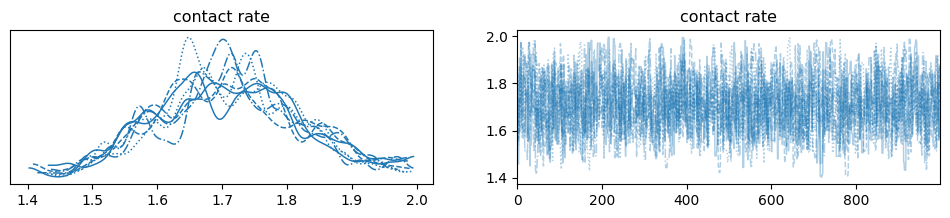

In [13]:
az.plot_trace(idata);

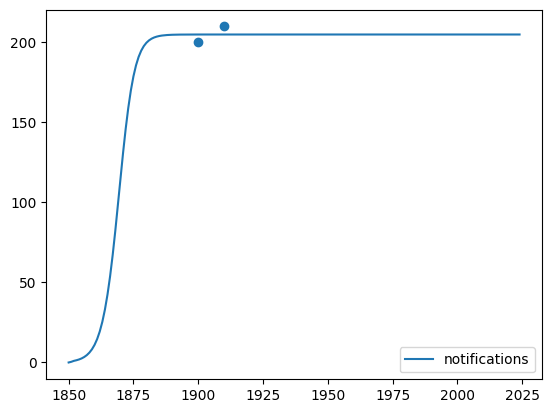

In [14]:
plot = model.get_derived_outputs_df().plot()
plot.scatter(dummy_target.index, dummy_target)